# Get Dataset

In [1]:
import data
from os import getcwd

In [7]:
data.parse_config('/Users/rich/monomer-orientation/config.cfg')

NoSectionError: No section: 'dataset'

In [17]:
test = [(1,12),(2,18),(7,19)]

In [14]:
import matplotlib.pyplot as plt

In [20]:
import pickle

In [28]:
test = pickle.load(open(PATH+'train_history','rb'))

In [29]:
test2 = pickle.load(open(PATH+'valid_history','rb'))

In [30]:
test2

[(0.0, tensor(498.4820, requires_grad=True)),
 (10.0, tensor(0.1077, requires_grad=True)),
 (20.0, tensor(0.1109, requires_grad=True)),
 (30.0, tensor(0.1504, requires_grad=True)),
 (40.0, tensor(0.0678, requires_grad=True)),
 (50.0, tensor(0.0712, requires_grad=True)),
 (60.0, tensor(0.0749, requires_grad=True)),
 (70.0, tensor(0.0482, requires_grad=True)),
 (80.0, tensor(0.0649, requires_grad=True)),
 (90.0, tensor(0.0584, requires_grad=True)),
 (100.0, tensor(0.0429, requires_grad=True)),
 (110.0, tensor(0.0500, requires_grad=True)),
 (120.0, tensor(0.0442, requires_grad=True)),
 (130.0, tensor(0.0413, requires_grad=True)),
 (140.0, tensor(0.0498, requires_grad=True)),
 (150.0, tensor(0.0521, requires_grad=True)),
 (160.0, tensor(0.0481, requires_grad=True)),
 (170.0, tensor(0.0367, requires_grad=True)),
 (180.0, tensor(0.0420, requires_grad=True)),
 (190.0, tensor(0.0492, requires_grad=True)),
 (200.0, tensor(0.0495, requires_grad=True)),
 (210.0, tensor(0.0362, requires_grad=True)

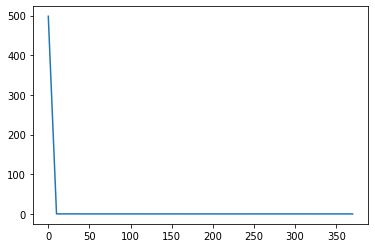

In [31]:
xs = [x[0] for x in test]
ys = [x[1] for x in test]
xs2 = [x[0] for x in test2]
ys2 = [x[1] for x in test2]
#plt.plot(xs, ys)
plt.plot(xs2, ys2)
plt.show()

In [8]:
PATH = getcwd() + '/'
config = data.parse_config(PATH + 'config.cfg')
trainset, validset, testset = data.get_dataset(config, rebuild=True)

In [5]:
trainset[0].shape

torch.Size([24024, 11, 11])

In [6]:
import train

In [ ]:
train

# Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import models

In [6]:
cnn = models.Net(config)

In [7]:
cnn

Net(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=200, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
cnn()

In [8]:
x = torch.randn(16,11,11).view((-1,1)+config.image_input_size)

In [16]:
validset[1][:16].view(-1,1).shape

torch.Size([16, 1])

In [14]:
cnn(x).shape

torch.Size([16, 1])

# Optimizer setup

In [9]:
import torch.optim as optim

In [10]:
batch_size = config.training_batch_size

In [11]:
def mean_angular_loss(prediction, target):
    angular_dist = torch.abs(prediction - target)
    losses = torch.where((90 < angular_dist) & (angular_dist <= 180), 180 - angular_dist, angular_dist)
    return torch.mean(losses**2)

In [12]:
optimizer = optim.Adam(cnn.parameters(), lr=config.learning_rate)

In [13]:
X_train = trainset[0]
y_train = trainset[1]
X_valid = validset[0]
y_valid = validset[1]

In [14]:
import matplotlib.pyplot as plt

In [15]:
i=0

tensor(0.)


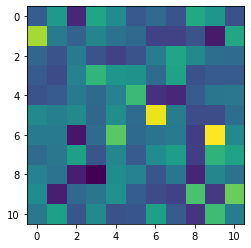

In [16]:
i+=1
print(y_train[i])
plt.imshow(X_train[i])

# Train

In [17]:
from tqdm import tqdm

In [18]:
def test(model, X_test, targets):
    preds = model(X_test)
    return mean_angular_loss(preds,targets)

In [19]:
history = []

In [34]:
for epoch in tqdm(range(config.num_epochs)):
    cnn.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].view((-1,1)+config.image_input_size)
        y_batch = y_train[i:i+batch_size]

        cnn.zero_grad()
        outputs = cnn(X_batch)
        loss = mean_angular_loss(outputs, y_batch)
        loss.backward()
        optimizer.step()
    
    cnn.eval()
    history.append(test(cnn, X_valid.view((-1,1)+config.image_input_size), y_valid))

100%|██████████| 4/4 [00:42<00:00, 10.74s/it]


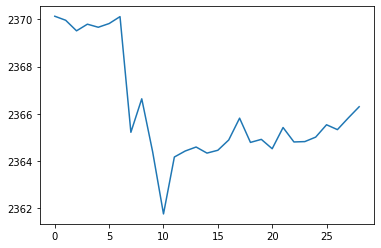

In [35]:
plt.plot(history)

In [22]:
loss

tensor(1850.7673, grad_fn=<MeanBackward0>)

In [27]:
cnn.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=200, bias=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=200, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)

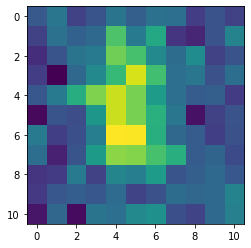

In [33]:
plt.imshow(X_valid[8])

In [37]:
out = cnn(X_valid.view(-1,1,11,11))

In [39]:
out.max()

tensor(30.5335, grad_fn=<MaxBackward1>)

In [ ]:
correct = 0
total = 0
cnn.eval()
with torch.no_grad():
    for i in tqdm(range(len(X_valid))):
        if cnn(X_valid[i]) 